# Project 3: Web APIs & NLP
## Part IV: Modeling

### 1. Import Libraries

In [109]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns 
import missingno as msno
from bs4 import BeautifulSoup
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, SMOTENC

#plotly imports
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# nltk imports:
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords

# scikit-learn imports:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, f1_score, balanced_accuracy_score, accuracy_score, RocCurveDisplay, roc_auc_score, recall_score, precision_score, confusion_matrix
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.metrics import precision_score, recall_score, accuracy_score, ConfusionMatrixDisplay, roc_auc_score
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingRegressor, BaggingClassifier, RandomForestClassifier, RandomForestRegressor, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier, GradientBoostingRegressor, GradientBoostingClassifier, HistGradientBoostingClassifier, HistGradientBoostingRegressor 
from sklearn.dummy import DummyClassifier 
from sklearn.datasets import fetch_openml
from sklearn.inspection import plot_partial_dependence
from sklearn import set_config
set_config(display = 'diagram')

In [110]:
crypto = pd.read_csv('../data/crypto_clean.csv')

In [111]:
crypto.head(2)

,year,is_btc,text_word_count,title_word_count,total_word_count,emoji,emoji_count,clean_text,clean_title,clean_title_and_text,clean_emoji
0,2021,1,322,4,325,💎🙌,2,hey my wsb friends i know some of you already ...,we like the coin,we like the coin hey my wsb friends i know som...,gem_stone raising_hands
1,2021,1,30,4,33,NaN,0,a friendly reminder don't share any personal i...,do not doxx yoself,do not doxx yoself a friendly reminder don't s...,NaN


In [112]:
crypto.shape

(2599, 11)

### 2. Null Model

In [132]:
X = crypto[['clean_title_and_text', 'clean_emoji']]
y = crypto['is_btc']

In [133]:
X.head()

,clean_title_and_text,clean_emoji
0,we like the coin hey my wsb friends i know som...,gem_stone raising_hands
1,do not doxx yoself a friendly reminder don't s...,NaN
2,as bitcoin s price surges affluent investors s...,NaN
3,what would happen to peoples bitcoin if robinh...,NaN
4,4 reasons to buy a lot of btc1 even the most s...,NaN


In [115]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2599 entries, 0 to 2598
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   clean_title_and_text  2599 non-null   object
 1   clean_emoji           246 non-null    object
dtypes: object(2)
memory usage: 40.7+ KB


In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 4, stratify = y)

In [117]:
y_train.value_counts(normalize=True)

1    0.6157
0    0.3843
Name: is_btc, dtype: float64

The basline score is about 62%. This means my models will have to beat about 62% to beat a null model (given stratify=y, that's how well predicting bitcoin every time would do in terms of the accuracy score).

### 3. Model Functions for Efficiency

Below are functions to simplify and expediate the testing of models and their parameters. Please see comments to understand the funcion's utility.

In [118]:
# function that lemmatizes text

def split_into_lemmas(text):
    '''return lowercased, lemmatizeed list of words as a string from a document passed in '''
   
    text = text.lower()
    lemmer = WordNetLemmatizer()
    return ' '.join([lemmer.lemmatize(word) for word in text.split() ])

In [119]:
# function that stems sentence to make it more understandable

def stem_sentence(sentence): 
    
    p_stemmer = PorterStemmer()
    return ' '.join([p_stemmer.stem(word) for word in sentence.split(' ')])

In [149]:
# function that does train test split, creates a pipline, and scores the given model with transformer
# this function assumes X has only one feature: clean_title_and_text

def model_score_no_moji(transformer, classifier, X,y):
    # train, test, split X and y 
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 4, stratify = y)
    
    # make pipeline
    pipe = make_pipeline(transformer, classifier)
    pipe.fit(X_train, y_train)
    
    # define score
    test_score = pipe.score(X_test, y_test)
    
    # print model and score
    print (f' model: {transformer, classifier}')
    return (f' test score: {test_score}')

In [159]:
# function that does train test split, creates a pipline, and scores the given model with transformer
# this function assumes X has two features: clean_title_and_text and clean_emoji

def model_score(transformer, classifier, X,y):
    # train, test, split X and y 
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 4, stratify = y)
    
    # make pipeline
    pipe = make_pipeline(transformer, classifier)
    pipe.fit(X_train, y_train)
    
    # define score
    # train_score = np.round(pipe.score(X_train, y_train), 3)
    test_score = np.round(pipe.score(X_test, y_test), 3)
    
    # print model and score
    print (f' model: {transformer, classifier}')
    #print (f' train score: {train_score}')
    return (f' test score: {test_score}')

In [1]:
# function that helps guage which hyperparameters to tune in order to avoid running too many parameters in Grid Search

def count_vec_options(classifier, X, y):
    # count vectorizer
    print(model_score(CountVectorizer(), classifier, X, y))
    print(model_score(CountVectorizer(stop_words = 'english'),classifier, X, y))
    print(model_score(CountVectorizer(stop_words = 'english', max_features = 1_000), classifier, X, y))
    print(model_score(CountVectorizer(preprocessor=split_into_lemmas), classifier, X, y))
    print(model_score(CountVectorizer(preprocessor=stem_sentence), classifier, X, y))
    print(model_score(CountVectorizer(ngram_range=(1,2)), classifier, X, y))

In [2]:
# function that helps guage which hyperparameters to tune in order to avoid running too many parameters in Grid Search

def tfidf_vec_options(classifier, X, y):
   # tfidf vectorizer
    print(model_score(TfidfVectorizer(), classifier, X, y))
    print(model_score(TfidfVectorizer(stop_words = 'english'), classifier, X, y))
    print(model_score(TfidfVectorizer(stop_words = 'english', max_features = 1_000), classifier, X, y))
    print(model_score(TfidfVectorizer(preprocessor=split_into_lemmas), classifier, X, y))
    print(model_score(TfidfVectorizer(preprocessor=stem_sentence), classifier, X, y))
    print(model_score(TfidfVectorizer(ngram_range=(1,2)), classifier, X, y))

### 4. Testing Models

I will try running all models with the same random state to ensure randomness doesn't affect the scores. Whichever models perform the best will be explored more in further steps with Grid Search.

In [123]:
lr = LogisticRegression(random_state=4)
knn = KNeighborsClassifier()
dtc = DecisionTreeClassifier(random_state=4)
bag = BaggingClassifier(random_state=4)
rfc = RandomForestClassifier(random_state=4)
ada = AdaBoostClassifier(random_state=4)
gb = GradientBoostingClassifier(random_state = 4)
#hgb = HistGradientBoostingClassifier()

In [3]:
models = [lr, knn, dtc, bag, rfc, ada, gb]

NameError: name 'lr' is not defined

**Setting X and y**

In [4]:
X = crypto['clean_title_and_text']

NameError: name 'crypto' is not defined

In [ ]:
for model in models:
    print(model_score_no_moji(CountVectorizer(), model, X, y))

 model: (CountVectorizer(), LogisticRegression(random_state=4))
 test score: 0.88
 model: (CountVectorizer(), KNeighborsClassifier())
 test score: 0.6938461538461539
 model: (CountVectorizer(), DecisionTreeClassifier(random_state=4))
 test score: 0.8692307692307693
 model: (CountVectorizer(), BaggingClassifier(random_state=4))
 test score: 0.8846153846153846
 model: (CountVectorizer(), RandomForestClassifier(random_state=4))
 test score: 0.8707692307692307
 model: (CountVectorizer(), AdaBoostClassifier(random_state=4))
 test score: 0.8492307692307692
 model: (CountVectorizer(), GradientBoostingClassifier(random_state=4))
 test score: 0.8369230769230769


In [154]:
X = crypto[['clean_title_and_text', 'clean_emoji']]

In [155]:
for model in models:
    print(model_score(CountVectorizer(), model, X, y))

 model: (CountVectorizer(), LogisticRegression(random_state=4))
 test score: 0.885
 model: (CountVectorizer(), KNeighborsClassifier())
 test score: 0.735
 model: (CountVectorizer(), DecisionTreeClassifier(random_state=4))
 test score: 0.888
 model: (CountVectorizer(), BaggingClassifier(random_state=4))
 test score: 0.894
 model: (CountVectorizer(), RandomForestClassifier(random_state=4))
 test score: 0.883
 model: (CountVectorizer(), AdaBoostClassifier(random_state=4))
 test score: 0.863
 model: (CountVectorizer(), GradientBoostingClassifier(random_state=4))
 test score: 0.822


The model scores are higher when X is set to clean_title_and_text and clean_emoji. Therefore, we will set X to these columns in the dataframe.

**Count Vectorizer**

In [156]:
for model in models:
    print(model_score(CountVectorizer(), model, X, y))

 model: (CountVectorizer(), LogisticRegression(random_state=4))
 test score: 0.885
 model: (CountVectorizer(), KNeighborsClassifier())
 test score: 0.735
 model: (CountVectorizer(), DecisionTreeClassifier(random_state=4))
 test score: 0.888
 model: (CountVectorizer(), BaggingClassifier(random_state=4))
 test score: 0.894
 model: (CountVectorizer(), RandomForestClassifier(random_state=4))
 test score: 0.883
 model: (CountVectorizer(), AdaBoostClassifier(random_state=4))
 test score: 0.863
 model: (CountVectorizer(), GradientBoostingClassifier(random_state=4))
 test score: 0.822


Count Vectorizer with Decision Tree Classifier and Count Vectorizer with Bagging Classifier appear to have high scores, so we will explore these models more below:

In [157]:
count_vec_options(DecisionTreeClassifier(random_state = 4), X, y)

 model: (CountVectorizer(), DecisionTreeClassifier(random_state=4))
 test score: 0.888
 model: (CountVectorizer(stop_words='english'), DecisionTreeClassifier(random_state=4))
 test score: 0.858
 model: (CountVectorizer(max_features=1000, stop_words='english'), DecisionTreeClassifier(random_state=4))
 test score: 0.865
 model: (CountVectorizer(preprocessor=<function split_into_lemmas at 0x7fed0e54e940>), DecisionTreeClassifier(random_state=4))
 test score: 0.877
 model: (CountVectorizer(preprocessor=<function stem_sentence at 0x7fed0e54e8b0>), DecisionTreeClassifier(random_state=4))
 test score: 0.878
 model: (CountVectorizer(ngram_range=(1, 2)), DecisionTreeClassifier(random_state=4))
 test score: 0.878


In [158]:
count_vec_options(BaggingClassifier(random_state=4), X, y)

 model: (CountVectorizer(), BaggingClassifier(random_state=4))
 test score: 0.894
 model: (CountVectorizer(stop_words='english'), BaggingClassifier(random_state=4))
 test score: 0.862
 model: (CountVectorizer(max_features=1000, stop_words='english'), BaggingClassifier(random_state=4))
 test score: 0.869
 model: (CountVectorizer(preprocessor=<function split_into_lemmas at 0x7fed0e54e940>), BaggingClassifier(random_state=4))
 test score: 0.889
 model: (CountVectorizer(preprocessor=<function stem_sentence at 0x7fed0e54e8b0>), BaggingClassifier(random_state=4))
 test score: 0.903
 model: (CountVectorizer(ngram_range=(1, 2)), BaggingClassifier(random_state=4))
 test score: 0.892


**Tfidf Vectorizer**

In [31]:
for model in models:
    print(model_score(TfidfVectorizer(), model, X, y)) 

 model: (TfidfVectorizer(), LogisticRegression(random_state=4))
 test score: 0.848
 model: (TfidfVectorizer(), KNeighborsClassifier())
 test score: 0.805
 model: (TfidfVectorizer(), DecisionTreeClassifier(random_state=4))
 test score: 0.86
 model: (TfidfVectorizer(), BaggingClassifier(random_state=4))
 test score: 0.895
 model: (TfidfVectorizer(), RandomForestClassifier(random_state=4))
 test score: 0.882
 model: (TfidfVectorizer(), AdaBoostClassifier(random_state=4))
 test score: 0.831
 model: (TfidfVectorizer(), GradientBoostingClassifier(random_state=4))
 test score: 0.866


Tfidf with Bagging Classifier and Tfidf with Random Forest Classifier appear to have high scores, so we will explore these models more below:

In [141]:
tfidf_vec_options(BaggingClassifier(random_state=4), X, y)

 model: (TfidfVectorizer(), BaggingClassifier(random_state=4))
 test score: 0.8953846153846153
 model: (TfidfVectorizer(stop_words='english'), BaggingClassifier(random_state=4))
 test score: 0.8876923076923077
 model: (TfidfVectorizer(max_features=1000, stop_words='english'), BaggingClassifier(random_state=4))
 test score: 0.8723076923076923
 model: (TfidfVectorizer(preprocessor=<function split_into_lemmas at 0x7fd37322de50>), BaggingClassifier(random_state=4))
 test score: 0.8984615384615384
 model: (TfidfVectorizer(preprocessor=<function stem_sentence at 0x7fd37322dee0>), BaggingClassifier(random_state=4))
 test score: 0.9
 model: (TfidfVectorizer(ngram_range=(1, 2)), BaggingClassifier(random_state=4))
 test score: 0.8938461538461538


In [142]:
tfidf_vec_options(RandomForestClassifier(random_state=4), X, y)

 model: (TfidfVectorizer(), RandomForestClassifier(random_state=4))
 test score: 0.8815384615384615
 model: (TfidfVectorizer(stop_words='english'), RandomForestClassifier(random_state=4))
 test score: 0.9
 model: (TfidfVectorizer(max_features=1000, stop_words='english'), RandomForestClassifier(random_state=4))
 test score: 0.8723076923076923
 model: (TfidfVectorizer(preprocessor=<function split_into_lemmas at 0x7fd37322de50>), RandomForestClassifier(random_state=4))
 test score: 0.88
 model: (TfidfVectorizer(preprocessor=<function stem_sentence at 0x7fd37322dee0>), RandomForestClassifier(random_state=4))
 test score: 0.8923076923076924
 model: (TfidfVectorizer(ngram_range=(1, 2)), RandomForestClassifier(random_state=4))
 test score: 0.8723076923076923


**After tests**


The best scores with each transformer are with the following models:
- 0.903: (CountVectorizer(preprocessor=<function stem_sentence at 0x7fd37322dee0>), BaggingClassifier(random_state=4)) 
- 0.900: (TfidfVectorizer(stop_words='english'), RandomForestClassifier(random_state=4)

Therefore, I will do grid searches with these models and parameters to attempt to achieve a higher score. 

### 6. Bagging

**Count Vectorizer**

In [248]:
ct = make_column_transformer(
    (CountVectorizer(preprocessor=stem_sentence), ('clean_title_and_text')),
    (OneHotEncoder(handle_unknown='ignore', sparse=False), ['clean_emoji']))

In [249]:
pipe = make_pipeline(ct, BaggingClassifier(random_state = 4))
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.9030769230769231

**Grid Search**

In [247]:
pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('tfidfvectorizer',
                                    TfidfVectorizer(stop_words='english'),
                                    'clean_title_and_text'),
                                   ('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    ['clean_emoji'])])),
  ('randomforestclassifier', RandomForestClassifier(random_state=4))],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('tfidfvectorizer',
                                  TfidfVectorizer(stop_words='english'),
                                  'clean_title_and_text'),
                                 ('onehotencoder',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse=False),
                          

In [250]:
grid = {
    'baggingclassifier__n_estimators': [10, 100],
    'columntransformer__countvectorizer__max_features': [None, 100, 1000],
}

In [253]:
gs = GridSearchCV(pipe, grid, n_jobs = -1, scoring = 'balanced_accuracy')
gs.fit(X_train, y_train)
gs.score(X_test, y_test)

0.8987499999999999

In [254]:
gs.best_params_

{'baggingclassifier__n_estimators': 10,
 'columntransformer__countvectorizer__max_features': None,
 'columntransformer__countvectorizer__preprocessor': <function __main__.stem_sentence(sentence)>}

Grid Search does not appear to work well for this model, so we will just consider the pipeline's test score. 

**Feature Importances and Coefficients**

Bagging classifier's feature importances are less interpretable than other models so we will get feature importances from the second best model below.

### 7. Random Forest

**Pipeline**

In [36]:
ct = make_column_transformer(
    (TfidfVectorizer(stop_words='english'), ('clean_title_and_text')),
    (OneHotEncoder(handle_unknown='ignore', sparse=False), ['clean_emoji']))

In [37]:
pipe = make_pipeline(ct,  RandomForestClassifier(random_state = 4))
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.9

In [38]:
pipe.score(X_train, y_train)

0.9979476654694716

**Grid Search**

In [93]:
pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('tfidfvectorizer',
                                    TfidfVectorizer(stop_words='english'),
                                    'clean_title_and_text'),
                                   ('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    ['clean_emoji'])])),
  ('randomforestclassifier', RandomForestClassifier(random_state=4))],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('tfidfvectorizer',
                                  TfidfVectorizer(stop_words='english'),
                                  'clean_title_and_text'),
                                 ('onehotencoder',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse=False),
                          

In [305]:
grid = {
    #'tfidfvectorizer__max_features': [None],# none is also option but taking it out
    'columntransformer__tfidfvectorizer__ngram_range': [(1,1), (1,2)],
    'randomforestclassifier__n_estimators': [1_000, 10_000],
    'randomforestclassifier__warm_start': [False, True],
    'randomforestclassifier__n_jobs': [-1]
}

gs = GridSearchCV(pipe, grid, n_jobs = -1)
gs.fit(X_train, y_train)
gs.score(X_test, y_test)

Process LokyProcess-70:
Traceback (most recent call last):
  File "/Users/olivialara/opt/anaconda3/envs/scikit1/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/olivialara/opt/anaconda3/envs/scikit1/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/olivialara/opt/anaconda3/envs/scikit1/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 477, in _process_worker
    gc.collect()
KeyboardInterrupt
Process LokyProcess-78:
Process LokyProcess-66:
Traceback (most recent call last):
  File "/Users/olivialara/opt/anaconda3/envs/scikit1/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/olivialara/opt/anaconda3/envs/scikit1/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/olivialara/opt/anaconda3/envs/scikit1/lib/python3.9/site-packages/

KeyboardInterrupt: 

In [ ]:
gs.best_params_

ocess_executor.py", line 477, in _process_worker
    gc.collect()
KeyboardInterrupt
Traceback (most recent call last):
  File "/Users/olivialara/opt/anaconda3/envs/scikit1/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/olivialara/opt/anaconda3/envs/scikit1/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/olivialara/opt/anaconda3/envs/scikit1/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 477, in _process_worker
    gc.collect()
KeyboardInterrupt
Process LokyProcess-68:
Traceback (most recent call last):
  File "/Users/olivialara/opt/anaconda3/envs/scikit1/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/olivialara/opt/anaconda3/envs/scikit1/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/olivialara/opt/anaconda3/envs/

Grid Search does not appear to work well for this model so we will just use the regular pipeline to find the feature importances.

**Feature Importances and Coefficients**

In [39]:
pipe.named_steps

{'columntransformer': ColumnTransformer(transformers=[('tfidfvectorizer',
                                  TfidfVectorizer(stop_words='english'),
                                  'clean_title_and_text'),
                                 ('onehotencoder',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse=False),
                                  ['clean_emoji'])]),
 'randomforestclassifier': RandomForestClassifier(random_state=4)}

In [40]:
feature_coefs = pipe.named_steps["randomforestclassifier"].feature_importances_

In [41]:
feature_coefs.shape

(8641,)

In [42]:
feature = pipe.named_steps['columntransformer'].get_feature_names_out()
feature

array(['tfidfvectorizer__00', 'tfidfvectorizer__000',
       'tfidfvectorizer__000cad', ...,
       'onehotencoder__clean_emoji_ wrapped_gift  dog_face  raising_hands ',
       'onehotencoder__clean_emoji_ zany_face  face_with_tears_of_joy ',
       'onehotencoder__clean_emoji_nan'], dtype=object)

In [43]:
feature.shape

(8641,)

In [73]:
feature_coef_df = pd.DataFrame({'Coefficients': feature_coefs, 'Feature': feature}).sort_values(by='Coefficients')
feature_coef_df_10 = feature_coef_df.tail(10)
feature_coef_df_10

,Coefficients,Feature
4470,0.007338,tfidfvectorizer__just
1847,0.007504,tfidfvectorizer__coinbase
5191,0.009045,tfidfvectorizer__moonempty
1241,0.010379,tfidfvectorizer__bitcoinempty
5190,0.016332,tfidfvectorizer__moon
1466,0.017934,tfidfvectorizer__btc
8640,0.024115,onehotencoder__clean_emoji_nan
2648,0.061276,tfidfvectorizer__dogecoin
2641,0.068737,tfidfvectorizer__doge
1231,0.105537,tfidfvectorizer__bitcoin


Now I will put the word_coef_df into a bar plot to better understand visually:

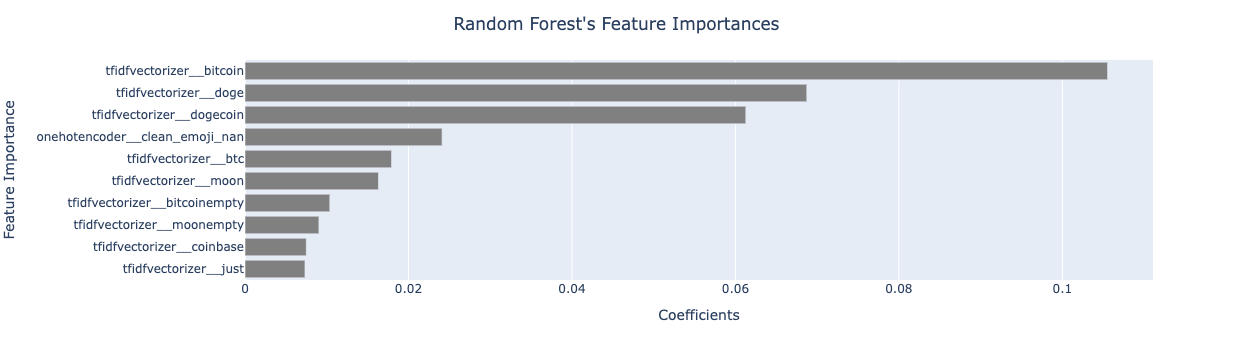

In [74]:
fig = px.bar(feature_coef_df_10, 
             orientation='h',
             y=feature_coef_df_10['Feature'],
             x=feature_coef_df_10['Coefficients'], 
             color_discrete_sequence = ['gray'],
             width = 10,
             labels={'Feature': 'Feature Importance'})

fig.update_layout(title = "Random Forest's Feature Importances", title_x=.5, yaxis = dict(tick0 = 0.5, dtick = 0.75))
fig.show()

This graph shows the top ten most important features for the Random Forest Model. It appears that-to no surprise-the words bitcoin, doge, and dogecoin are the features that are most significant to the model. Another important feture is clean_emoji_nan, implying that an empty emoji value is significant to the model when determining whether a post is from Dogecoin or Bitcoin. This could be due to the fact that in this dataset emojis ares used .03% of the time in Bitcoin posts and 20% of the time in Dogecoin posts.

Let's see ONLY the top ten most important WORDS:

In [83]:
tfidf_df = feature_coef_df[feature_coef_df['Feature'].str.startswith('tfidf')].tail(10)

In [84]:
tfidf_df

,Coefficients,Feature
4675,0.007246,tfidfvectorizer__let
4470,0.007338,tfidfvectorizer__just
1847,0.007504,tfidfvectorizer__coinbase
5191,0.009045,tfidfvectorizer__moonempty
1241,0.010379,tfidfvectorizer__bitcoinempty
5190,0.016332,tfidfvectorizer__moon
1466,0.017934,tfidfvectorizer__btc
2648,0.061276,tfidfvectorizer__dogecoin
2641,0.068737,tfidfvectorizer__doge
1231,0.105537,tfidfvectorizer__bitcoin


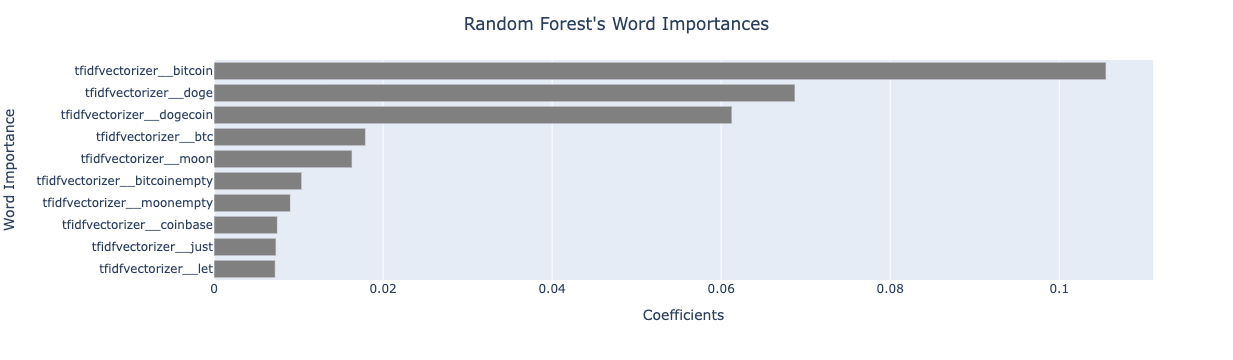

In [89]:
fig = px.bar(tfidf_df, 
             orientation='h',
             y=tfidf_df['Feature'],
             x=tfidf_df['Coefficients'], 
             color_discrete_sequence = ['gray'],
             width = 10,
             labels={'Feature': 'Word Importance'})

fig.update_layout(title = "Random Forest's Word Importances", title_x=.5, yaxis = dict(tick0 = 0.5, dtick = 0.75))
fig.show()

Let's see ONLY the top ten most important EMOJIS:

In [86]:
ohe_df = feature_coef_df[feature_coef_df['Feature'].str.startswith('onehot')].tail(10)

In [87]:
ohe_df.sort_values(by='Coefficients',ascending=False)

,Coefficients,Feature
8640,0.024115,onehotencoder__clean_emoji_nan
8526,0.001638,onehotencoder__clean_emoji_ dog
8608,0.001099,onehotencoder__clean_emoji_ rocket rocket ro...
8589,0.000702,onehotencoder__clean_emoji_ person_facepalming...
8548,0.000454,onehotencoder__clean_emoji_ face_with_tears_of...
8600,0.000436,onehotencoder__clean_emoji_ rocket
8515,0.000435,onehotencoder__clean_emoji_ beaming_face_with_...
8638,0.000403,onehotencoder__clean_emoji_ wrapped_gift dog_...
8517,0.000393,onehotencoder__clean_emoji_ blue_heart
8599,0.000384,onehotencoder__clean_emoji_ robot grinning_fa...


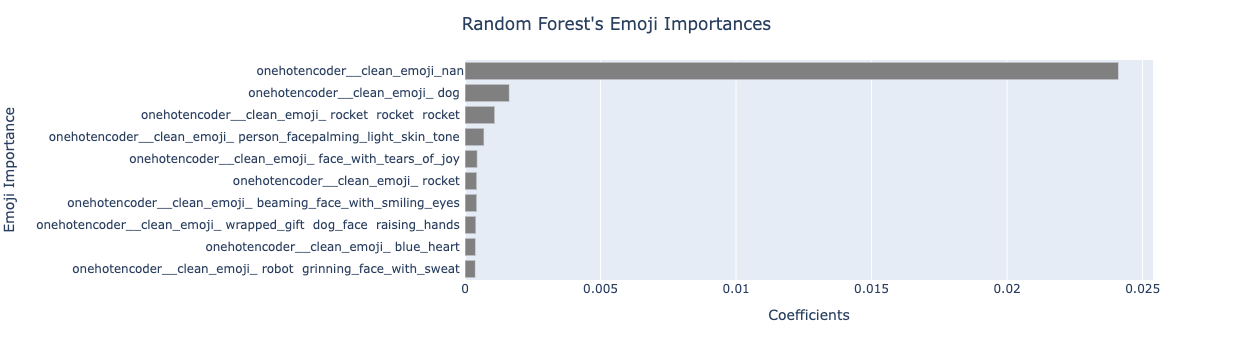

In [90]:
fig = px.bar(ohe_df, 
             orientation='h',
             y=ohe_df['Feature'],
             x=ohe_df['Coefficients'], 
             color_discrete_sequence = ['gray'],
             width = 10,
             labels={'Feature': 'Emoji Importance'})

fig.update_layout(title = "Random Forest's Emoji Importances", title_x=.5, yaxis = dict(tick0 = 0.5, dtick = 0.75))
fig.show()

**Other Metrics**

In [91]:
y_preds = pipe.predict(X_test)

In [92]:
balanced_accuracy_score(y_test, y_preds)

0.8985000000000001

### 8. Conclusion

**Scores**

In summary, Bagging Classifier with Count Vectorizer had an accuracy score of .903 and Random Forest with TfidfVectorizer had an accuracy score of .900, making them my most effective models. 

**Features**

The most significant word features were as follows: bitcoin, doge, and dogecoin. Their coefficients were 0.106, 0.069, and 0.061 respectively.  The most significant emoji feature was emoji_nan, with a coefficient of 0.024.

**Answer to Problem Statment** 

We were able to correctly predict the classifation of a subreddit post (-r/Bitcoin or -r/Dogecoin) for approximately 90% of the posts in our y_test. The features mentioned above impact our classification model the most. After EDA and finding the feature importances, it is evident that Bitcoin Reddit authors post lengthier mosts, meanwhile Dogecoin Reddit authors have posts that include more emojis.